# Lab 2: Photometry and Spectroscopy of the Low and High Redshift Universe


**Lab 2a:**

Today we will begin working with available online image data and analysis tools.  

Initially, we will perform simple aperture photometry on Pan-STARRS observations of QSOs at low and high redshifts (based on measurements using SDSS).  

Among the key python modules we will use are astroquery (for obtaining catalog data), and photutils for analyzing the data and performing photometry

[Astroquery](https://astroquery.readthedocs.io/en/latest/)

[Photutils](https://photutils.readthedocs.io/en/stable/)

The Photutils tutorials are very useful for quickly getting up to speed performing photometry on astronomical images.  We'll only do basic aperture photometry today.

We will also make use of [Speclite](https://speclite.readthedocs.io/en/latest/) to display survey filter functions

**Today's goals (9/30/24)**



*   Explore each part of the notebook, and familiarize yourself with what each section is doing
*   Calculate the background-subtracted aperture flux and calibrated aperture magnitudes for each of the four QSOs used as examples.  In the last section of the notebook is an initial template for using PhotUtils to perform aperture photometry on the Pan-Starrs QSO data for a single band image.  How can we measure a background-subtracted flux using an aperture measurement and a surrounding annulus measurement? Extend this analysis to all of the images and all bands.


*   The four multi-band images are shown for example QSOs drawn from SDSS.  Think about what might be causing the differences in appearance between low and high redshift QSOs?  There is also a 'lens' QSO that may have multiple images, that may require further investigation.

* Also, why does the multi-band Crab Nebula image look so unusual?








In [1]:
# For today's lab we will make use of three packages that need to be downloaded into Colaboratory
!pip install astroquery
!pip install speclite
!pip install photutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 861.5/861.5 kB 5.9 MB/s eta 0:00:00


### Speclite

Speclite is useful as a database and for visualizing filter curves from astronomical telescopes

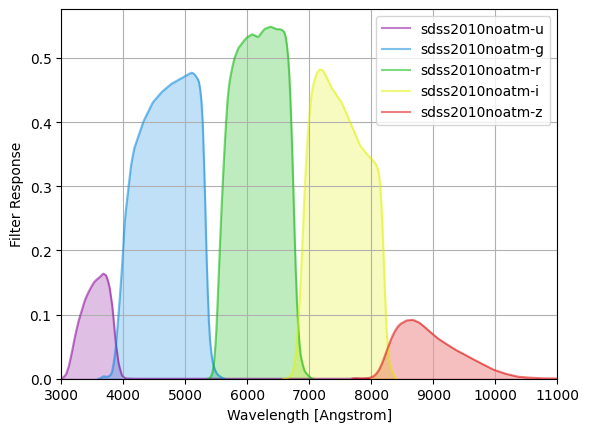

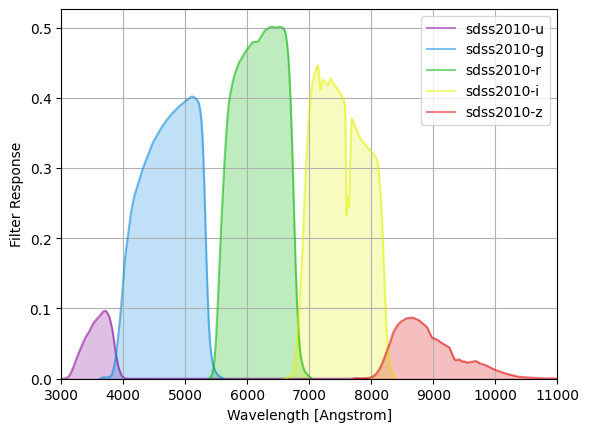

In [2]:
import speclite
import speclite.filters

sdss_noatm = speclite.filters.load_filters('sdss2010noatm-*')
speclite.filters.plot_filters(sdss_noatm, wavelength_limits=(3000, 11000))

import speclite.filters
sdss = speclite.filters.load_filters('sdss2010-*')
speclite.filters.plot_filters(sdss, wavelength_limits=(3000, 11000))

### Pan-STARRS filter curves

Since Pan-STARRS isn't in Speclite we'll need to add them, reading from a table associated with an ApJ article

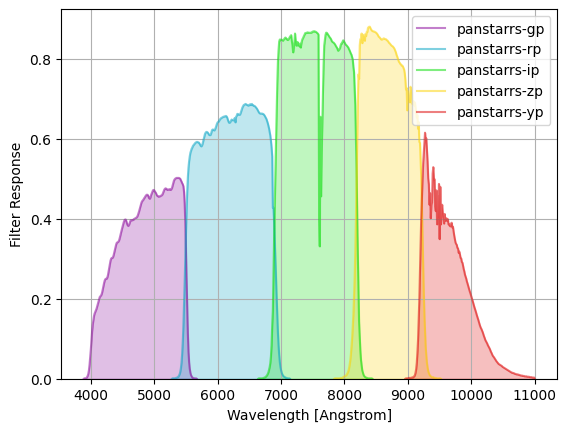

In [3]:
from astropy.table import Table
from astropy import units as u

t = Table.read("https://ipp.ifa.hawaii.edu/ps1.filters/apj425122t3_mrt.txt",format="ascii.mrt")

panstarrs_gp = speclite.filters.FilterResponse(
    wavelength = t['Wave'].value*10 * u.Angstrom,
    response = t['gp1'].value, meta=dict(group_name='panstarrs', band_name='gp'))
panstarrs_rp = speclite.filters.FilterResponse(
    wavelength = t['Wave'].value*10 * u.Angstrom,
    response = t['rp1'].value, meta=dict(group_name='panstarrs', band_name='rp'))
panstarrs_ip = speclite.filters.FilterResponse(
    wavelength = t['Wave'].value*10 * u.Angstrom,
    response = t['ip1'].value, meta=dict(group_name='panstarrs', band_name='ip'))
panstarrs_zp = speclite.filters.FilterResponse(
    wavelength = t['Wave'].value*10 * u.Angstrom,
    response = t['zp1'].value, meta=dict(group_name='panstarrs', band_name='zp'))
ypfix=t['yp1'].value
ypfix[-1]=0
panstarrs_yp = speclite.filters.FilterResponse(
    wavelength = t['Wave'].value*10 * u.Angstrom,
    response = ypfix, meta=dict(group_name='panstarrs', band_name='yp'))

panstarrs = speclite.filters.load_filters('panstarrs-gp','panstarrs-rp','panstarrs-ip','panstarrs-zp','panstarrs-yp')
speclite.filters.plot_filters(panstarrs)



Below is setup for Pan-STARRS image access

The link below shows a general notebook regarding access, from which we've borrowed utility functions

https://spacetelescope.github.io/mast_notebooks/notebooks/PanSTARRS/PS1_image/PS1_image.html

In [4]:
import matplotlib.pyplot as plt
import numpy
import requests
import warnings
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.visualization import PercentileInterval, AsinhStretch
from io import BytesIO
from PIL import Image

In [5]:
# Pan-STARRS Utility function to get list of images
def get_image_table(ra,dec,filters="grizy"):
    """
    Query ps1filenames.py service to get a list of images

    ra, dec = position in degrees
    filters = string with filters to include. includes all by default
    Returns a table with the results
    """
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    # The final URL appends our query to the PS1 image service
    url = f"{service}?ra={ra}&dec={dec}&filters={filters}"
    # Read the ASCII table returned by the url
    table = Table.read(url, format='ascii')
    return table

# Pan-STARRS Utility function to get URL for images in the table
def get_imurl(ra, dec, size=240, output_size=None, filters="grizy", im_format="jpg", color=False):
    """
    Get URL for images in the table

    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include. choose from "grizy"
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
    # Check for user input errors
    if color and (im_format == "fits"):
        raise ValueError("color images are available only for jpg or png formats")
    if im_format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")

    # Call the original helper function to get the table
    table = get_image_table(ra,dec,filters=filters)
    url = (f"https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           f"ra={ra}&dec={dec}&size={size}&format={im_format}")

    # Append an output size, if requested
    if output_size:
        url = url + f"&output_size={output_size}"

    # Sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[numpy.argsort(flist)]

    if color:
        # We need at least 3 filters to create a color image
        if len(table) < 3:
            raise ValueError("at least three filters are required for an RGB color image")
        # If more than 3 filters, pick 3 filters from the availble results
        if len(table) > 3:
            table = table[[0,len(table)//2,len(table)-1]]
        # Create the red, green, and blue files for our image
        for i, param in enumerate(["red","green","blue"]):
            url = url + f"&{param}={table['filename'][i]}"

    else:
        # If not a color image, only one filter should be given.
        if len(table)>1:
            warnings.warn('Too many filters for monochrome image. Using only 1st filter.')
        # Use red for monochrome images
        urlbase = url + "&red="
        url = []
        filename = table[0]['filename']
        url = urlbase+filename
    return url

# Pan-STARRS Utility function to return image for URL
def get_im(ra, dec, size=240, output_size=None, filters="g", im_format="jpg", color=False):
    """
    Get image at a sky position. Depends on get_imurl

    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    im_format = data format (options are "jpg", "png","fits")
    Returns the image
    """
    # For either format, we need the image URL
    url = get_imurl(ra,dec,size=size,filters=filters,output_size=output_size,im_format=im_format,color=color)
    if im_format == "fits":
        fh = fits.open(url)
        # The image is contained within the data unit
        fits_im = fh[0].data
        fits_hdr = fh[0].header
        im=fits_im
        # Set contrast to something reasonable
#        transform = AsinhStretch() + PercentileInterval(99.5)
        transform = PercentileInterval(99.5)
        im = transform(fits_im)
        return im,fits_hdr
    else:
        # JPEG is easy. Request the file, read the bytes
        r = requests.get(url)
        im = Image.open(BytesIO(r.content))
        fits_hdr=''
        return im

### Plot Pan-STARRS images for the Crab Nebula

Just to see that things are working!

In [6]:
# This just shows that the routines work and that you are able to access the database
# Crab Nebula Coordinates
ra_crab = 83.633210
dec_crab = 22.014460

# Call our helper function
get_image_table(ra_crab,dec_crab)

projcell,subcell,ra,dec,filter,mjd,type,filename,shortname,badflag
int64,int64,float64,float64,str1,float64,str5,str70,str43,int64
1784,59,83.63321,22.01446,g,0.0,stack,/rings.v3.skycell/1784/059/rings.v3.skycell.1784.059.stk.g.unconv.fits,rings.v3.skycell.1784.059.stk.g.unconv.fits,0
1784,59,83.63321,22.01446,i,0.0,stack,/rings.v3.skycell/1784/059/rings.v3.skycell.1784.059.stk.i.unconv.fits,rings.v3.skycell.1784.059.stk.i.unconv.fits,0
1784,59,83.63321,22.01446,r,0.0,stack,/rings.v3.skycell/1784/059/rings.v3.skycell.1784.059.stk.r.unconv.fits,rings.v3.skycell.1784.059.stk.r.unconv.fits,0
1784,59,83.63321,22.01446,y,0.0,stack,/rings.v3.skycell/1784/059/rings.v3.skycell.1784.059.stk.y.unconv.fits,rings.v3.skycell.1784.059.stk.y.unconv.fits,0
1784,59,83.63321,22.01446,z,0.0,stack,/rings.v3.skycell/1784/059/rings.v3.skycell.1784.059.stk.z.unconv.fits,rings.v3.skycell.1784.059.stk.z.unconv.fits,0


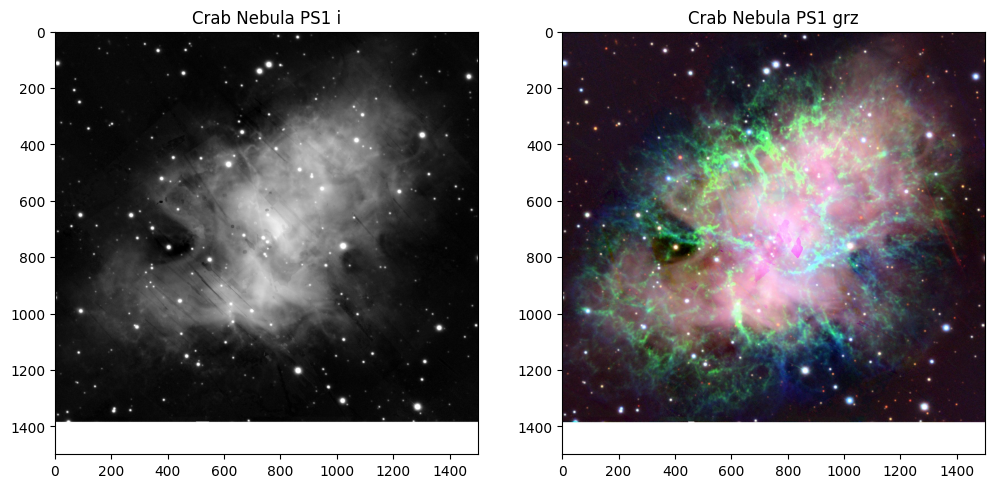

In [7]:
# Show crab nebula, as a single band grayscale and a 'grz' color image
# Set image size
size = 1500

# Greyscale image
gim = get_im(ra_crab, dec_crab, size=size, im_format='jpg', filters="i", color=False)
# Color image
cim = get_im(ra_crab, dec_crab, size=size, im_format='jpg', filters="grz", color=True)

# Create the figure
plt.figure(1,(12,6))

# Grey image subplot on left
plt.subplot(121)
plt.imshow(gim,origin="upper",cmap="gray")
plt.title('Crab Nebula PS1 i')

# Color image subplot on right
plt.subplot(122)
plt.title('Crab Nebula PS1 grz')
plt.imshow(cim,origin="upper")


Text(0.5, 1.0, 'Crab Nebula PS1 i (fits)')

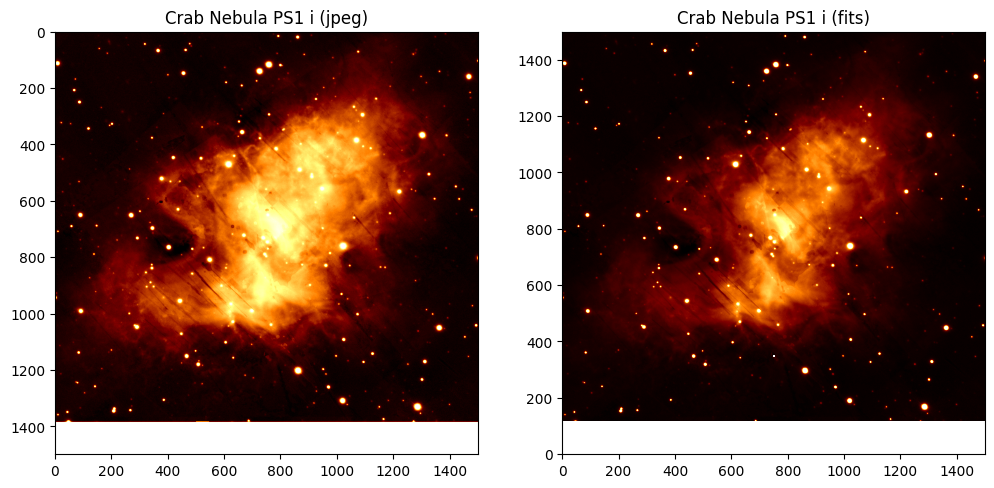

In [8]:
# Test the fits routine functions
# Get a new fits image in the 'i' band
fitsim,hdr = get_im(ra_crab, dec_crab, size=size, filters="i", im_format="fits")

plt.figure(1,(12,6))
# As before, plot the grayscale JPG on the left
plt.subplot(121)
plt.imshow(gim, origin="upper",cmap='afmhot')
plt.title('Crab Nebula PS1 i (jpeg)')

# Now plot the greyscale FITS on the right
plt.subplot(122)
plt.imshow(fitsim, origin="lower", cmap='afmhot')
plt.title('Crab Nebula PS1 i (fits)')

# QSO targets

* Load targets first from a table of candidate/confirmed lensed QSOs
* Load hi and lo redshift QSOs from SDSS DR16 QSO catalog


In [9]:
# Access lensed QSO table
from astroquery.vizier import Vizier
from astropy.coordinates import Angle
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance


catalog_list = Vizier.find_catalogs('lens quasar')
for k, v in catalog_list.items():
      print(k, ":", v.description)

# This is a supplemental table of candidate/confirmed lensed QSOs
# Note limit is 50 rows, but can be extended
catalog='J/AJ/143/119/table6'
print('Loading:',catalog)
result_qso2 = Vizier.get_catalogs(catalog=catalog)
# Print out the table
print(result_qso2[0])

J/ApJ/887/126 : Follow-up obs. of the PSJ0147+4630 lens system (Goicoechea+, 2019)
J/ApJ/921/42 : Gaia GraL. VI. Quadruply imaged lensed QSOs (Stern+, 2021)
J/A+A/300/323 : NOT GL survey of multiply imaged quasars (Jaunsen+, 1995)
J/A+A/391/481 : R-band photometry of SBS1520+530 (Burud+, 2002)
J/A+A/618/A56 : Gaia GraL. II. Known multiply imaged quasars (Ducourant+, 2018)
J/AJ/132/999 : SDSS quasar lens search (Oguri+, 2006)
J/AJ/135/496 : SDSS quasar lens search. II. (Inada+, 2008)
J/AJ/140/403 : SDSS Quasar Lens Search. IV. (Inada+, 2010)
J/AJ/143/119 : SDSS Quasar Lens Search. V. Final catalog (Inada+, 2012)
Loading: J/AJ/143/119/table6
 S          SDSS        f_SDSS  N    zs   ... Sloan Simbad    _RA       _DE   
                                          ...                 deg       deg   
--- ------------------- ------ --- ------ ... ----- ------ --------- ---------
    J013435.66-093102.9          5  2.220 ... Sloan Simbad  23.64858  -9.51747
    J014516.59-094517.3          2  

In [10]:
# Here we're going to access an SDSS QSO catalog from the DR16 data release
from astroquery.vizier import Vizier
from astropy.coordinates import Angle
catalog_list = Vizier.find_catalogs('sdss qso')
for k, v in catalog_list.items():
      print(k, ":", v.description)


#goodsn=SkyCoord('12:36:44.27 62:14:24.48',unit=(u.hour, u.deg),frame='icrs')
qsotarg=SkyCoord(191.720649,58.712544,unit=u.deg,frame='icrs')

# Select out hi-z qsos - settings are currently designed to extract a cuople of good high-z QSOs from SDSS
# Select out low-z qsos - Could be any low-z near here, but we'll take the first one on the list
result_hi = Vizier.query_region(qsotarg, radius=Angle(1, "deg"), column_filters={"z":">4.5"},catalog='VII/289/dr16q')
result_lo = Vizier.query_region(qsotarg, radius=Angle(0.1, "deg"), column_filters={"z":"<0.5","z":">0.25"},catalog='VII/289/dr16q')
print(result_hi[0]['z'])
print(result_lo[0]['z'])

II/294 : The SDSS Photometric Catalog, Release 7 (Adelman-McCarthy+, 2009)
V/139 : The SDSS Photometric Catalog, Release 9 (Adelman-McCarthy+, 2012)
V/147 : The SDSS Photometric Catalogue, Release 12 (Alam+, 2015)
V/154 : Sloan Digital Sky Surveys (SDSS), Release 16 (DR16) (Ahumada+, 2020)
VII/258 : Quasars and Active Galactic Nuclei (13th Ed.) (Veron-Cetty+ 2010)
VII/289 : SDSS quasar catalog, sixteenth data release (DR16Q) (Lyke+, 2020)
J/ApJS/189/1 : A 3.5mm polarimetric survey of radio-loud AGNs (Agudo+, 2010)
     z     
-----------
   6.000869
   6.661811
     z     
-----------
   1.667676
   2.218523
   1.290351
   6.000869
   1.751000


# Pan-STARRS Cutout Images of QSO targets

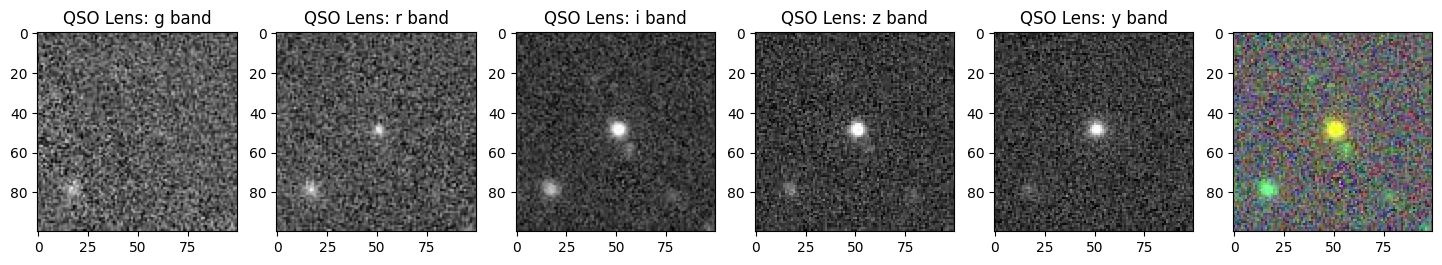

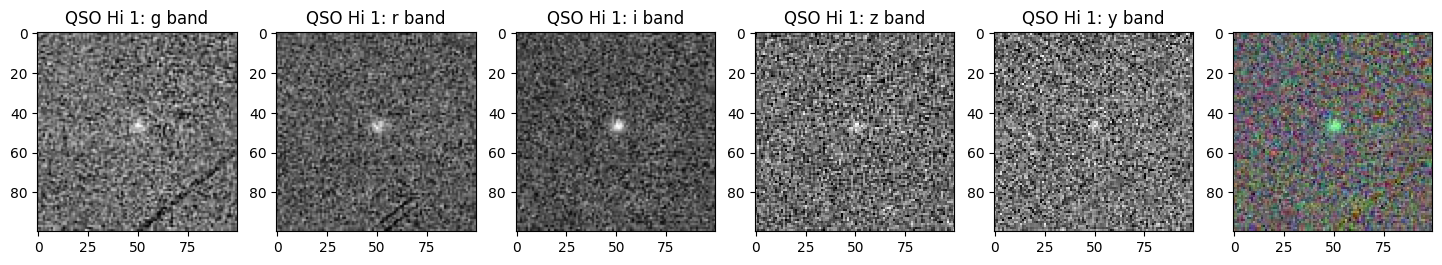

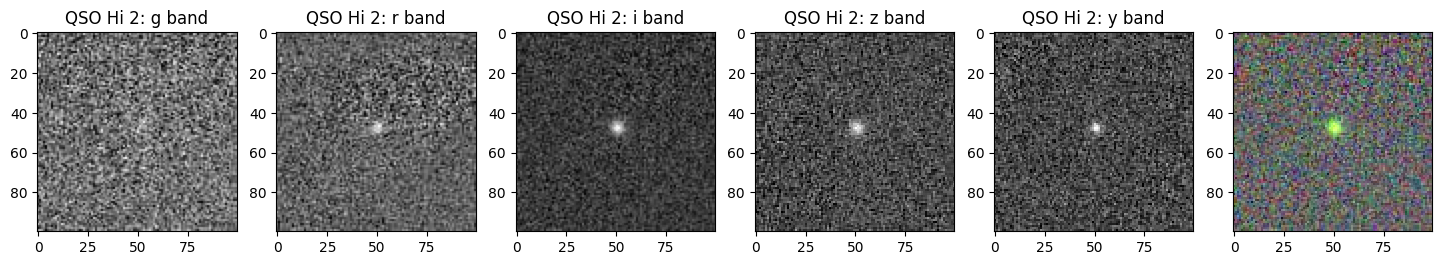

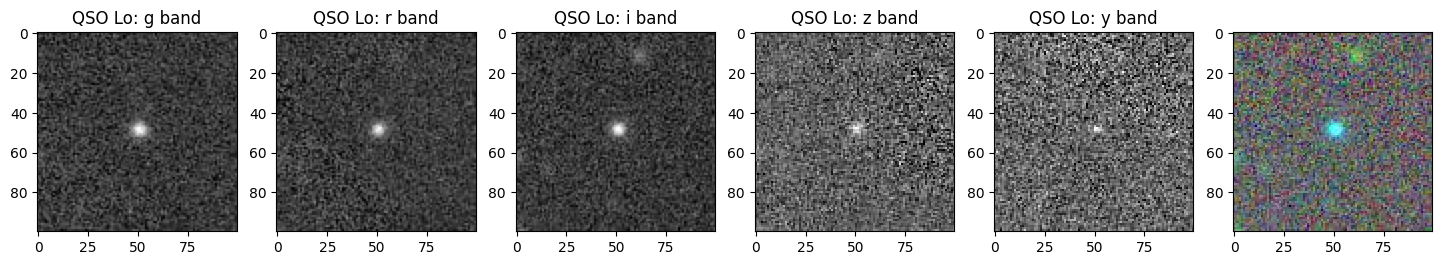

In [11]:
def panstarrs_cutout_plot(ra,dec,size,title):
   filterlist=['g','r','i','z','y']

   plt.figure(1,(18,3))

# Greyscale images

   for filter,cntr in zip(filterlist,np.arange(6)+1):
      plt.subplot(1,6,cntr)
      gim = get_im(ra, dec, size=size, output_size=size,im_format='jpg', filters=filter, color=False)
      plt.imshow(gim,origin="upper",cmap="gray")
      plt.title(title+': '+filter+' band')
      cntr+=1

# Color image
   cim = get_im(ra, dec, size=size, output_size=size,im_format='jpg', filters="giy", color=True)

   plt.subplot(1,6,6)
   plt.imshow(cim,origin="upper")
   plt.show()

ra=result_qso2[0][0]['_RA']
dec=result_qso2[0][0]['_DE']
# Set image size
size = 100
title='QSO Lens'
panstarrs_cutout_plot(ra,dec,size,title)

ra=result_hi[0][0]['RAJ2000']
dec=result_hi[0][0]['DEJ2000']
# Set image size
size = 100
title='QSO Hi 1'
panstarrs_cutout_plot(ra,dec,size,title)

ra=result_hi[0][1]['RAJ2000']
dec=result_hi[0][1]['DEJ2000']
# Set image size
size = 100
title='QSO Hi 2'
panstarrs_cutout_plot(ra,dec,size,title)

ra=result_lo[0][0]['RAJ2000']
dec=result_lo[0][0]['DEJ2000']
# Set image size
size = 100
title='QSO Lo'
panstarrs_cutout_plot(ra,dec,size,title)



# Photometry of Pan-STARRS images of QSOs, using PhotUtils

* First, load fits image and display
* Then define apertures (using PhotUtils tools) and display
* Finally make background-subtracted flux measurements

191.659172 58.694747
SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                  100 / length of data axis 1                          NAXIS2  =                  100 / length of data axis 2                          EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H DATE    = '2024-09-30T17:50:15' / file creation date (YYYY-MM-DDThh:mm:ss UT)   CTYPE1  = 'RA---TAN'                                                            CTYPE2  = 'DEC--TAN'                                                            CRVAL1  =     194.399993896494                                                  CRVAL2  =      57.9

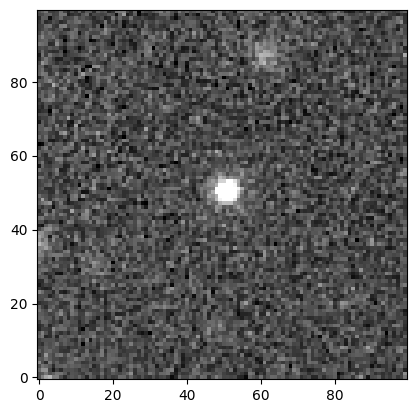

In [12]:

ra=result_lo[0][0]['RAJ2000']
dec=result_lo[0][0]['DEJ2000']
print(ra,dec)
# Set image size
size = 100
filter = 'ip'

ifits,hdr = get_im(ra, dec, size=size, output_size=size,im_format='fits', filters=filter, color=False)
print(hdr)
plt.imshow(ifits,origin="lower",cmap="gray")

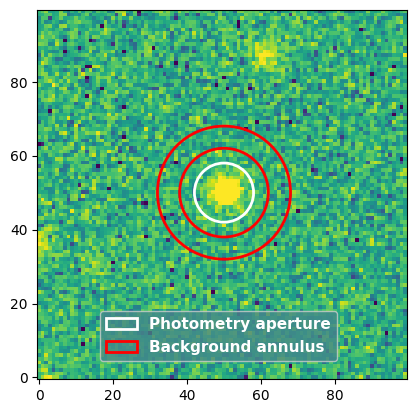

In [13]:
from astropy.visualization import simple_norm
from photutils.aperture import CircularAnnulus, CircularAperture

data=ifits

positions = [(50, 50)]
aperture = CircularAperture(positions, r=8)
annulus_aperture = CircularAnnulus(positions, r_in=12, r_out=18)

norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')


ap_patches = aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
         handles=handles, prop={'weight': 'bold', 'size': 11})

In [14]:
from astropy.stats import sigma_clipped_stats
from photutils.aperture import ApertureStats, CircularAperture

aperstats = ApertureStats(data, aperture[0])
annulus_aperstats = ApertureStats(data, annulus_aperture[0])

# Some values from aperstats
print('x, y centroid:',np.round((aperstats.xcentroid,aperstats.ycentroid),3))
print('mean,median,std:',np.round((aperstats.mean, aperstats.median, aperstats.std),3))
print('aperture sum:',np.round(aperstats.sum,3))
print('background annulus sum:',np.round(annulus_aperstats.sum,3))


# This is approximate
flux= aperstats.sum-aperture.area*annulus_aperstats.mean
print('Annulus mean, aperture area [pixels], aperture sum - annulus mean * aperture area)',np.round(annulus_aperstats.mean,aperture.area,aperstats.sum-aperture.area*annulus_aperstats.mean),4)
#For now assume zero point = 25  - We will address this further...!

x, y centroid: [50.326 50.136]
mean,median,std: [0.519 0.452 0.243]
aperture sum: 102.552
background annulus sum: 166.554


TypeError: integer argument expected, got float